# Part 2: Fundamental Matrix Estimation, Camera Calibration, Triangulation

In [297]:
import numpy as np
import matplotlib.pyplot as plt


## Fundamental Matrix Estimation

In [1]:
def normalize_points(points):
    # n points, d dimensions
    n, d = points.shape

    # center all the points
    centroid = np.mean(points, axis=0)
    points0 = points - centroid

    # scale each points till mean squared distance is 2 px
    rms = np.sqrt(np.sum(points0 ** 2) / n)
    scale = np.sqrt(d) / rms

    matrix = np.eye(d + 1)
    # scale
    for i in range(d + 1):
        matrix[i, i] = scale
    # translation
    matrix[:d, -1] = -centroid * scale

    # apply the matrix on all points
    points = np.vstack([points.T, np.ones(n)])
    points = (matrix @ points).T
    points = points[:, :d] / points[:, d:]

    return points, matrix


def fit_fundamental(matches, normalize=False):
    src, dst = matches[:, :2], matches[:, 2:]
    if normalize:
        src, src_matrix = normalize_points(src)
        dst, dst_matrix = normalize_points(dst)

    # (x'x, x'y, x',  y'x, y'y, y',  x, y,  1)
    n = len(matches)
    A = np.hstack(
        [
            dst[:, 0][:, np.newaxis] * src,
            dst[:, 0][:, np.newaxis],
            dst[:, 1][:, np.newaxis] * src,
            dst[:, 1][:, np.newaxis],
            src,
            np.ones((n, 1)),
        ]
    )

    _, _, vh = np.linalg.svd(A, full_matrices=False)
    F = vh[-1, :].reshape(3, 3)

    # enforce rank-2
    u, s, vh = np.linalg.svd(F, full_matrices=False)
    s[2] = 0
    F = u @ np.diag(s) @ vh

    if normalize:
        # fix the matrix, since we do normalization on points
        F = dst_matrix.T @ F @ src_matrix

    return F


** F **
[[-1.32341616e-06  1.36640519e-05 -6.82803870e-04]
 [-2.88178174e-05  2.66440807e-07  4.09069255e-02]
 [ 5.62362952e-03 -3.72771609e-02 -9.98451273e-01]]

residuals=0.179213px


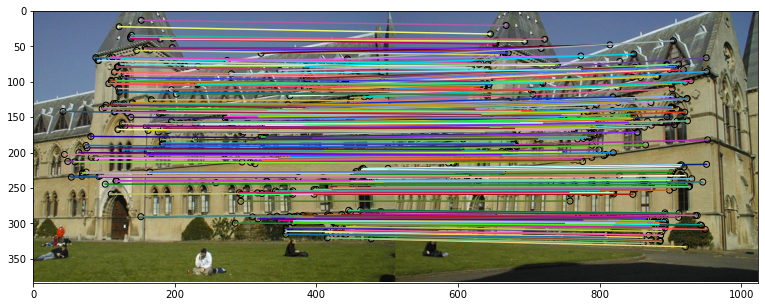

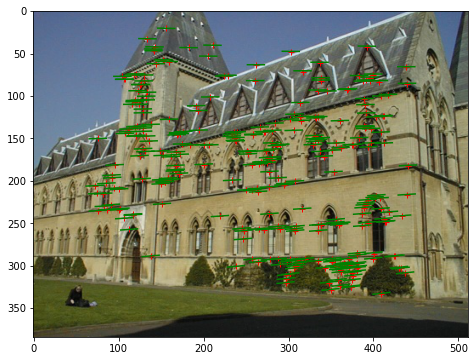

In [307]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import plot_matches

##
## load images and match files for the first example
##

name = "library"
I1 = imread(f"part2/{name}1.jpg")
I2 = imread(f"part2/{name}2.jpg")
matches = np.loadtxt(f"part2/{name}_matches.txt")

# this is a N x 4 file where the first two numbers of each row
# are coordinates of corners in the first image and the last two
# are coordinates of corresponding corners in the second image:
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is a corresponding point in the second image

N = len(matches)

##
## display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
##

fig, ax = plt.subplots(figsize=(15, 5))
plot_matches(
    ax,
    I1,
    I2,
    matches[:, :2][:, ::-1],
    matches[:, 2:][:, ::-1],
    np.array([(i, i) for i in range(N)]),
)

##
## display second image with epipolar lines reprojected
## from the first image
##

# first, fit fundamental matrix to the matchess
F = fit_fundamental(matches, normalize=False)
print("** F **")
print(F)
print()

# raise RuntimeError
# this is a function that you should write
M = np.c_[matches[:, 0:2], np.ones((N, 1))].transpose()
L1 = (F @ M).T  # transform points from
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:, 0] ** 2 + L1[:, 1] ** 2)
L = np.divide(L1, np.kron(np.ones((3, 1)), l).transpose())  # rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:, 2:4], np.ones((N, 1))]).sum(axis=1)
closest_pt = matches[:, 2:4] - np.multiply(
    L[:, 0:2], np.kron(np.ones((2, 1)), pt_line_dist).transpose()
)

# calculate residuals
residuals = np.mean(pt_line_dist ** 2)
print(f"residuals={residuals:.6f}px")

# find endpoints of segment on epipolar line (for display purposes)
pt1 = (
    closest_pt - np.c_[L[:, 1], -L[:, 0]] * 10
)  # offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:, 1], -L[:, 0]] * 10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect("equal")
ax.imshow(I2)
ax.plot(matches[:, 2], matches[:, 3], "+r")
ax.plot([matches[:, 2], closest_pt[:, 0]], [matches[:, 3], closest_pt[:, 1]], "r")
ax.plot([pt1[:, 0], pt2[:, 0]], [pt1[:, 1], pt2[:, 1]], "g")
plt.show()

ax.axis("off")
fig.savefig("F-est_unnormalized.png", bbox_inches="tight", pad_inches=0)


Esimate without matching ground truth.

In [72]:
# this block is directly copy from Part 1

import cv2 as cv
from skimage.feature.util import FeatureDetector, DescriptorExtractor
from skimage.util import img_as_ubyte


class SIFT(FeatureDetector, DescriptorExtractor):
    """
    Wrapper class for OpenCV to use scikit-image detector-extractor.
    
    Args:
        n_features (int, optional): The number of best features to retain. 
        n_octave_layers (int, optional): The number of layers in each octave.
        contrast_threshold (float, optional): The contrast threshold used to filter out 
            weak features in semi-uniform (low-contrast) regions.
        edge_threshold (float, optional): The threshold used to filter out edge-like 
            features. 
        sigma (float, optional): The sigma of the Gaussian applied to the input image 
            at the 0th octave.
    """

    def __init__(
        self,
        n_features=100,
        n_octave_layers=3,
        contrast_threshold=0.04,
        edge_threshold=10,
        sigma=1.6,
    ) -> None:
        self.detector = cv.SIFT_create(
            nfeatures=n_features,
            nOctaveLayers=n_octave_layers,
            contrastThreshold=contrast_threshold,
            edgeThreshold=edge_threshold,
            sigma=sigma,
        )

        self.keypoints = None
        self.descriptors = None

    def detect(self, image) -> None:
        # cv only takes in 8U
        image = img_as_ubyte(image)
        self.keypoints_ = self.detector.detect(image)

        # extract relevant info from cv structure
        self.keypoints = np.array([keypoint.pt[::-1] for keypoint in self.keypoints_])

    def extract(self, image, keypoints=None) -> None:
        if keypoints is not None:
            raise NotImplementedError(f"'keypoints' has no effect, using cached result")

        # cv only takes in 8U
        image = img_as_ubyte(image)
        _, self.descriptors = self.detector.compute(image, self.keypoints_)


from scipy.spatial.distance import cdist


def swap_by(v, cond):
    v[cond, 0], v[cond, 1] = v[cond, 1], v[cond, 0]
    return v


def ubcmtach(desc1, desc2, threshold):
    """
    Matches two sets of SIFT descriptors.append
    
    This function uses the algorithm suggested by D. Lowe to reject matches that are too ambiguous.
    
    Args:
        desc1 : 
        desc2 :
        threshold (float): 

    Returns:
        TBD
    """
    dist2 = cdist(desc1, desc2, metric="sqeuclidean")

    # find 1st and 2nd closest match distance
    index_closest = np.argpartition(dist2, 2)[:, :2]
    dist_closest = np.take_along_axis(dist2, index_closest, axis=-1)
    # sort in each partition
    need_swap = dist_closest[:, 0] > dist_closest[:, 1]
    index_closest = swap_by(index_closest, need_swap)
    dist_closest = swap_by(dist_closest, need_swap)

    # compare ratio
    index_closest_mask = dist_closest[:, 0] * threshold < dist_closest[:, 1]

    matches = [
        (m0, m1)
        for m0, (m1, mask) in enumerate(zip(index_closest[:, 0], index_closest_mask))
        if mask
    ]
    matches = np.array(matches)

    return matches, dist_closest[index_closest_mask, 0]


from skimage.measure.fit import BaseModel
from skimage.transform._geometric import _center_and_normalize_points


class HomographyModel(BaseModel):
    def estimate(self, src, dst) -> bool:
        """
        Estimate homography model from data.

        Args:
            data ((N, 4) array): N points in a 2D space, arrange in (x1, y1, x2, y2).

        Returns:    
            bool: True if model sucessfully estimates.
        """
        n = len(src)

        A1 = np.hstack(
            [
                src,
                np.ones((n, 1)),
                np.zeros((n, 3)),
                -dst[:, 0][:, np.newaxis] * src,
                -dst[:, 0][:, np.newaxis],
            ]
        )

        A2 = np.hstack(
            [
                np.zeros((n, 3)),
                src,
                np.ones((n, 1)),
                -dst[:, 1][:, np.newaxis] * src,
                -dst[:, 1][:, np.newaxis],
            ]
        )

        A = np.empty((2 * n, A1.shape[-1]))
        A[0::2, :] = A1
        A[1::2, :] = A2

        _, _, vh = np.linalg.svd(A, full_matrices=False)
        if np.isclose(vh[-1, -1], 0):
            return False

        # save the H
        self.params = np.reshape(vh[-1, :], (3, 3))

        return True

    def residuals(self, src, dst):
        """
        Determine residuals of data to model.

        Args:
            src ((N, 2) array): Source coordinates.
            dst ((N, 2) array): Destination coordinates

        Returns:
            (N, ) array: 
        """
        return np.hypot(*(self.predict(src) - dst).T)

    def predict(self, data):
        """
        Predict x-y coordinates using the estimated model.

        Args:
            data ((N, 2) array):

        Returns:
            (N, 2) array: 
        """
        n = len(data)

        data = np.hstack([data, np.ones((n, 1))])
        data_fit = data @ self.params.T
        # convert back from homogeneous coordinate
        data_fit = data_fit[:, :-1] / data_fit[:, -1][:, np.newaxis]

        return data_fit


def ransac(
    data,
    model_class,
    min_samples,
    residual_threshold,
    max_trials=100,
    random_state=None,
):
    """
    RANSAC

    Args:
        data ((N, 2) array): 
        model_class :
        min_samples (int): Minimum number of data points to fit the model.
        residual_threshold (float): Maximum distance for a data point to be classified 
            as an inlier.
        max_trials (int, optional): Maximum number of iterations for RANSAC.
        random_State ({None, int, `numpy.random.Generator`}, optional): A seed to 
            initialize the BitGenerator.
    """
    n_samples = len(data)

    # model for this dataset, following skimage.measure.fit.BaseModel
    model = model_class()

    random_state = np.random.default_rng(random_state)

    best_inliers_num = 0
    # best_residuals_sum = np.inf
    best_residuals_mean = np.inf
    best_inliers = []

    for i_trial in range(max_trials):
        # select subset, forbit duplicate item
        sampling_mask = random_state.choice(n_samples, min_samples, replace=False)
        samples = data[sampling_mask, :]

        success = model.estimate(samples[:, 2:], samples[:, :2])
        if not success:
            # fail to fit for some reason
            continue
        residuals = np.abs(model.residuals(data[:, 2:], data[:, :2]))

        inliers = residuals < residual_threshold
        # residuals_sum = np.sum(residuals ** 2)
        residuals_mean = np.mean(residuals[inliers] ** 2)
        inliers_num = np.count_nonzero(inliers)

        if (
            # more inliers
            (inliers_num > best_inliers_num)
            # same number of inliers, but less residuals sum
            or (
                (inliers_num == best_inliers_num)
                # and (residuals_sum < best_residuals_sum)
                and (residuals_mean < best_residuals_mean)
            )
        ):
            best_inliers = inliers
            # best_residuals_sum = residuals_sum
            best_residuals_mean = residuals_mean
            best_inliers_num = inliers_num

            # TODO early stop conditions

    if best_inliers.any():
        # print(f".. best_residual_sum={best_residuals_sum:.6f}")
        print(f".. best_residual_mean={best_residuals_mean:.6f}")
        print(f".. best_inliers_num={best_inliers_num}")

        # estimate the model with all inliers
        data_inliers = data[best_inliers, :]
        model.estimate(data_inliers[:, 2:], data_inliers[:, :2])
    else:
        model = None
        best_inliers = None

    return model, best_inliers


image 0, 1001 keypoints
image 1, 1000 keypoints
0<>1, 284 matches


/home/andy/.conda/envs/ece549-mp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andy/.conda/envs/ece549-mp/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1559/4061964891.py:182: RuntimeWarning: divide by zero encountered in true_divide
  data_fit = data_fit[:, :-1] / data_fit[:, -1][:, np.newaxis]


.. best_residual_mean=0.230261
.. best_inliers_num=50
0<>1, [ransac] 50 inliers
(50, 4)
** F **
[[ 4.909e-08 -4.260e-07  1.093e-05]
 [ 3.144e-07 -4.241e-08 -3.093e-05]
 [-2.341e-05  5.485e-05  3.600e-04]]

residuals=0.000000px


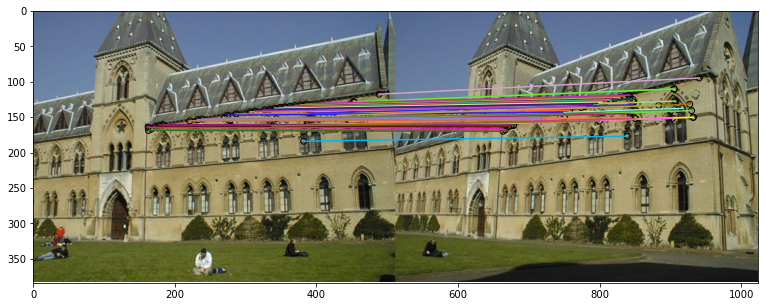

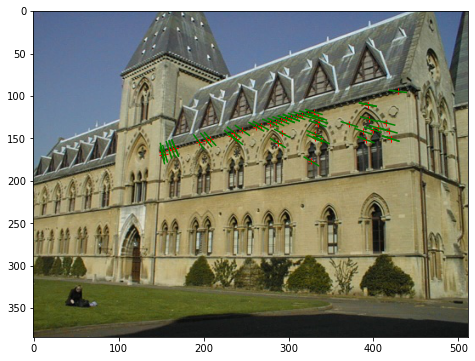

In [87]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import plot_matches

from matplotlib.patches import Circle
from skimage.feature import plot_matches
from skimage.transform import warp, EuclideanTransform, ProjectiveTransform

##
## load images and match files for the first example
##

name = "library"
I1 = imread(f"part2/{name}1.jpg")
I2 = imread(f"part2/{name}2.jpg")
matches_gt = np.loadtxt(f"part2/{name}_matches.txt")

images = [I1, I2]
keypoints = []
descriptors = []
matches = [[]]  # ignore first comparison
models = []

keypoints_raw = []

# feature extraction
detector = SIFT(n_features=1000)

for i, image in enumerate(images):
    detector.detect(image)
    keypoints.append(detector.keypoints)
    print(f"image {i}, {len(detector.keypoints)} keypoints")
    keypoints_raw.append(detector.keypoints_)

    detector.extract(image)
    descriptors.append(detector.descriptors)

# putative matches
i_ref = 0
for i_src in range(1, len(images)):
    new_matches, score = ubcmtach(
        descriptors[i_ref], descriptors[i_src], 1.5
    )
    print(f"{i_ref}<>{i_src}, {len(new_matches)} matches")
    matches.append(new_matches)

# build data array for RANSAC
i_ref = 0
for i_src in range(1, len(images)):
    m_ref = keypoints[i_ref][matches[i_src][:, 0], :]
    m_src = keypoints[i_src][matches[i_src][:, 1], :]

    # flip from y-x to x-y
    data = np.hstack([m_ref[:, ::-1], m_src[:, ::-1]])

    model, inliers = ransac(
        data,
        HomographyModel,
        min_samples=4,
        residual_threshold=1,
        max_trials=10000,
    )
    print(f"{i_ref}<>{i_src}, [ransac] {np.count_nonzero(inliers)} inliers")
    models.append(model)

    # update match result with inliers-only
    matches[i_src] = matches[i_src][inliers, :]

    # calculate target match
    m_src = m_src[inliers, :]
    m_dst_fit = model.predict(m_src[:, ::-1])[:, ::-1]

    # show fitting result
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_matches(
        ax,
        images[i_ref],
        images[i_src],
        m_dst_fit,
        m_src,
        np.array([(i, i) for i in range(len(m_src))]),
    )

fig.savefig("F-est_ransac.png", bbox_inches="tight", pad_inches=0)


# this is the matches 
matches = np.hstack([m_dst_fit[:, ::-1], m_src[:, ::-1]])
print(matches.shape)

# copy back original estimation script

N = len(matches)

##
## display second image with epipolar lines reprojected
## from the first image
##

# first, fit fundamental matrix to the matchess
F = fit_fundamental(matches, normalize=True)
print("** F **")
print(F)
print()

# raise RuntimeError
# this is a function that you should write
M = np.c_[matches[:, 0:2], np.ones((N, 1))].transpose()
L1 = (F @ M).T  # transform points from
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:, 0] ** 2 + L1[:, 1] ** 2)
L = np.divide(L1, np.kron(np.ones((3, 1)), l).transpose())  # rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:, 2:4], np.ones((N, 1))]).sum(axis=1)
closest_pt = matches[:, 2:4] - np.multiply(
    L[:, 0:2], np.kron(np.ones((2, 1)), pt_line_dist).transpose()
)

# calculate residuals
residuals = np.mean(pt_line_dist ** 2)
print(f"residuals={residuals:.6f}px")

# find endpoints of segment on epipolar line (for display purposes)
pt1 = (
    closest_pt - np.c_[L[:, 1], -L[:, 0]] * 10
)  # offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:, 1], -L[:, 0]] * 10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect("equal")
ax.imshow(I2)
ax.plot(matches[:, 2], matches[:, 3], "+r")
ax.plot([matches[:, 2], closest_pt[:, 0]], [matches[:, 3], closest_pt[:, 1]], "r")
ax.plot([pt1[:, 0], pt2[:, 0]], [pt1[:, 1], pt2[:, 1]], "g")
plt.show()

ax.axis("off")
fig.savefig("F-est_nogt.png", bbox_inches="tight", pad_inches=0)


## Camera Calibration

In [3]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u - points_2d[:, 0], v - points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual


### **Lab** pair, estimate projection matrix using ground truth 3D points

In [18]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import plot_matches

##
## load match and ground truth files
##

points_2d = [np.loadtxt(f"part2/lab_matches.txt")[:, i : i + 2] for i in (0, 2)]
points_3d = np.loadtxt(f"part2/lab_3d.txt")


def calibrate(points_2d, points_3d):
    n = len(points_2d)

    A1 = np.hstack(
        [
            np.zeros((n, 4)),
            points_3d,
            np.ones((n, 1)),
            -points_2d[:, 1][:, np.newaxis] * points_3d,
            -points_2d[:, 1][:, np.newaxis],
        ]
    )

    A2 = np.hstack(
        [
            points_3d,
            np.ones((n, 1)),
            np.zeros((n, 4)),
            -points_2d[:, 0][:, np.newaxis] * points_3d,
            -points_2d[:, 0][:, np.newaxis],
        ]
    )

    A = np.empty((2 * n, A1.shape[-1]))
    A[0::2, :] = A1
    A[1::2, :] = A2

    _, _, vh = np.linalg.svd(A.T @ A, full_matrices=False)
    if np.isclose(vh[-1, -1], 0):
        return False

    p = vh[-1, :].reshape(-1, 4)

    return p


matrix = []
for i, points_2d_subset in enumerate(points_2d, 1):
    p = calibrate(points_2d_subset, points_3d)
    with np.printoptions(precision=3):
        print(f'lab{i}, p=')
        print(p)
    matrix.append(p)
    points_3d_proj, residuals = evaluate_points(p, points_2d_subset, points_3d)

    dist2 = np.mean((points_3d_proj - points_2d_subset) ** 2)
    print(f"residuals={residuals}, avg_dist2={dist2}")
    print()

lab1, p=
[[-3.100e-03 -1.462e-04  4.485e-04  9.789e-01]
 [-3.070e-04 -6.372e-04  2.774e-03  2.041e-01]
 [-1.679e-06 -2.748e-06  6.840e-07  1.329e-03]]
residuals=13.545776180285374, avg_dist2=0.39307573725611594

lab2, p=
[[-6.932e-03  4.017e-03  1.326e-03  8.267e-01]
 [-1.548e-03 -1.025e-03  7.274e-03  5.625e-01]
 [-7.609e-06 -3.710e-06  1.902e-06  3.388e-03]]
residuals=15.5449069211823, avg_dist2=0.372832413946974



### Run this to load projection matrix directly for **library**

In [15]:
matrix = [np.loadtxt(f"part2/library{i}_camera.txt") for i in (1, 2)]


## Camera Centers

[ 314.461 -305.357 -108.947]
[ 69.814 -61.839 -71.186]


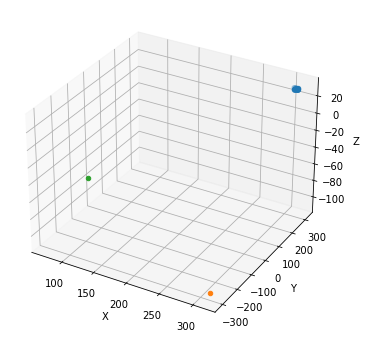

In [19]:
def camera_center(P):
    _, _, vh = np.linalg.svd(P, full_matrices=False)
    if np.isclose(vh[-1, -1], 0):
        return False

    K = vh[-1, :]
    K = K[:3] / K[3]

    return K

# plot lab 3D ground truth
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(*points_3d.T, 'b')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

for m in matrix:
    c = camera_center(m)
    print(c)
    ax.scatter(*c, 'r')

fig.savefig("camera-center_lab.png", bbox_inches="tight", pad_inches=0)


## Triangulation

In [64]:
def triangulate(x1, x2, P1, P2):
    M = np.zeros((6,6))
    M[:3,:4] = P1
    M[3:,:4] = P2
    M[:3,4] = -x1
    M[3:,5] = -x2

    _, _, vh = np.linalg.svd(M)
    X = vh[-1,:4]

    X = X[:3] / X[3]

    """
    Xp = np.hstack([X, 1, 0, 0])
    print('Xp=')
    print(Xp)

    Y = M @ Xp
    print('M=')
    print(M)

    print('Y=')
    print(Y)
    print(Y[:2] / Y[2])
    print(Y[3:] / Y[-1])

    Xp = np.hstack([X, 1])
    x1p = P1 @ Xp
    print('x1p=')
    print(x1p / x1p[-1])
    print(x1)
    """

    return X

X = []
for x1, x2 in zip(*points_2d):
    # to homogenous coordinate
    x1 = np.hstack([x1, 1])
    x2 = np.hstack([x2, 1])

    X12 = triangulate(x1, x2, *matrix)
    X.append(X12)

X = np.stack(X, axis=0)

dist2 = np.mean((points_3d - X) ** 2)
print(f"avg_dist2={dist2}")

avg_dist2=0.0002665242531190642


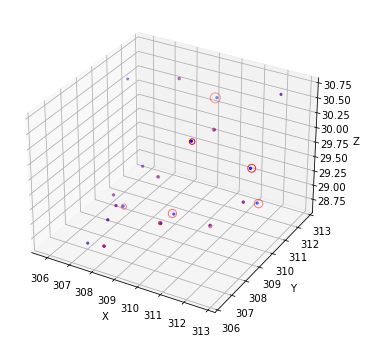

In [63]:
# plot lab 3D ground truth
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(*points_3d.T, c='b', marker='.')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# and triangulated results
s = (points_3d - X) ** 2
s = np.hypot(*s.T)
s /= np.max(s)
ax.scatter(*X.T, s=100*s, marker='o', facecolors='none', edgecolor='r')

fig.savefig("triangulation_lab.png", bbox_inches="tight", pad_inches=0)

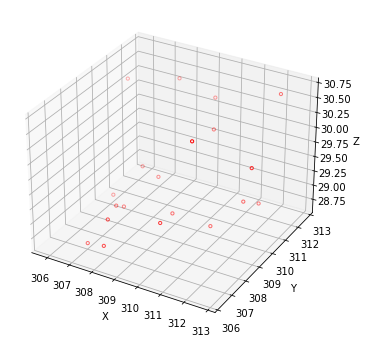

In [67]:
# plot library 3D, no ground truth
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(*X.T, s=10, marker='o', facecolors='none', edgecolor='r')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

fig.savefig("triangulation_library.png", bbox_inches="tight", pad_inches=0)